In [1]:
import numpy as np

all_chroma_vectors = np.load('data/01_all_chroma_vectors.npy')
all_chord_labels = np.load('data/01_all_chord_labels.npy')
all_chroma_vectors.shape, all_chord_labels.shape

((3360513, 24), (3360513,))

#### Bit of analysis

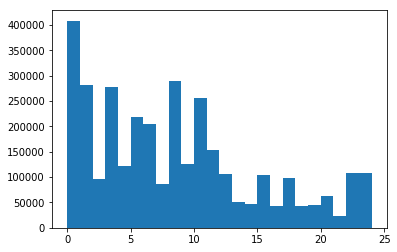

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

counts, _, _ = plt.hist(all_chord_labels, bins=list(set(all_chord_labels)))
plt.show()

In [16]:
min(counts), max(counts)

(22911.0, 408735.0)

Since minimum counts is ~20000, w/c is already a lot, we can get maybe around 1000 from each class as test set, 4000 from each class as validation set on 5 different splits, splits w/o overlapping data points.

#### Splitting

In [2]:
from numpy.random import default_rng

_SEED = 0

# test; must always return same result in successive runs
x = [1,2,3,4,5,6,7,8,9]
rng = default_rng(seed=_SEED)
rng.shuffle(x)

# re-seeding allows to get similar shuffles for diff.arrays
y = [11,22,33,44,55,66,77,88,99]
rng = default_rng(seed=_SEED)
rng.shuffle(y)

z = [0,1,2,3,4,5,6,7,8]
rng = default_rng(seed=_SEED)
rng.shuffle(z)

x, y, z

([5, 6, 3, 7, 4, 9, 8, 1, 2],
 [55, 66, 33, 77, 44, 99, 88, 11, 22],
 [4, 5, 2, 6, 3, 8, 7, 0, 1])

In [3]:
def shuffle_set(array_set):
    """ Shuffle in unison all arrays in array_set """
    for arr in array_set:
        rng = default_rng(seed=_SEED)
        rng.shuffle(arr)
    
    return array_set

x = [1,2,3,4,5,6,7,8,9]
y = [11,22,33,44,55,66,77,88,99]
z = [0,1,2,3,4,5,6,7,8]
x,y,z = shuffle_set((x,y,z))

x,y,z

([5, 6, 3, 7, 4, 9, 8, 1, 2],
 [55, 66, 33, 77, 44, 99, 88, 11, 22],
 [4, 5, 2, 6, 3, 8, 7, 0, 1])

We'll shuffle first before splitting to add some randomness in the data.

In [33]:
import numpy as np

_NUM_TEST_PER_CLASS = 1 #1000
_NUM_VAL_PER_CLASS = 4 #4000
_NUM_VAL_SPLITS = 5

class QueueData():
    def __init__(self, dataset):
        self.dataset = dataset
        self.st_ix = 0
    
    def take(self, num):
        st, ed = self.st_ix, self.st_ix+num
        queue_out = tuple(data[st:ed] for data in self.dataset)
        self.st_ix = ed
        return queue_out
    
    def flush(self):
        st, ed = self.st_ix, len(self.dataset[0])
        queue_out = tuple(data[st:ed] for data in self.dataset)
        return queue_out

class SplitData():
    def __init__(self, feats=None, labels=None):
        self.feats = feats
        self.labels = labels
        
    def push(self, feats, labels):
        assert(len(feats)==len(labels))
        if self.feats is None:
            self.feats = feats
        else:
            self.feats = np.concatenate((self.feats, feats))
        
        if self.labels is None:
            self.labels = labels
        else:
            self.labels = np.concatenate((self.labels, labels))
    
    def __len__(self):
        return len(self.labels)

    @property
    def shape(self):
        return (self.feats.shape, self.labels.shape)

def get_splits(feats, labels, validate=True):
    """ Return training, validation, and test sets """
    classes = list(set(labels))
    classes.sort()
    
    if validate:
        hist, _ = np.histogram(labels, bins=classes)
        assert(min(hist) >= (_NUM_TEST_PER_CLASS + (_NUM_VAL_SPLITS*_NUM_VAL_PER_CLASS)))
    
    test_split = SplitData()
    val_splits = [SplitData() for i in range(_NUM_VAL_SPLITS)]
    train_split = SplitData()
    
    for cls in classes:
        mask = (labels==cls)
        queue = QueueData(dataset=(feats[mask], labels[mask]))
        
        test_split.push(*queue.take(_NUM_TEST_PER_CLASS))
        for ix in range(_NUM_VAL_SPLITS):
            val_splits[ix].push(*queue.take(_NUM_VAL_PER_CLASS))
        train_split.push(*queue.flush())

    return train_split, val_splits, test_split

train_split, val_splits, test_split = get_splits(all_chroma_vectors[:100], all_chord_labels[:100])

In [18]:
print(train_split.shape)
for val_split in val_splits:
    print(val_split.shape)
print(test_split.shape)

((58, 24), (58,))
((8, 24), (8,))
((8, 24), (8,))
((8, 24), (8,))
((8, 24), (8,))
((8, 24), (8,))
((2, 24), (2,))


In [19]:
_NUM_TEST_PER_CLASS = 1000
_NUM_VAL_PER_CLASS = 4000
_NUM_VAL_SPLITS = 5

all_chroma_vectors, all_chord_labels = shuffle_set((all_chroma_vectors, all_chord_labels))
train_split, val_splits, test_split = get_splits(all_chroma_vectors, all_chord_labels)

print(train_split.shape)
for val_split in val_splits:
    print(val_split.shape)
print(test_split.shape)

((2835513, 24), (2835513,))
((100000, 24), (100000,))
((100000, 24), (100000,))
((100000, 24), (100000,))
((100000, 24), (100000,))
((100000, 24), (100000,))
((25000, 24), (25000,))


In [44]:
def get_next_cv_split(train_split, val_splits):
    num_cv = len(val_splits)
    for v_ix in range(num_cv): # index of val split at a specific round
        addl_train_splits = val_splits[0:v_ix] + val_splits[v_ix+1:]
        val_split = val_splits[v_ix]
        
        full_train_feats = np.concatenate((train_split.feats,
                                           *[split.feats for split in addl_train_splits]))
        full_train_labels = np.concatenate((train_split.labels,
                                            *[split.labels for split in addl_train_splits]))
        full_train_split = SplitData(feats=full_train_feats,labels=full_train_labels)
        yield full_train_split, val_split
            
        
for train, val in get_next_cv_split(train_split, val_splits):
    print(len(train), len(val))

3235513 100000
3235513 100000
3235513 100000
3235513 100000
3235513 100000


Try with the dataloader module

In [1]:
from dataloader import SimpleChromaDataset

ds = SimpleChromaDataset(feat_label_files=('data/01_all_chroma_vectors.npy',
                                           'data/01_all_chord_labels.npy'))

Loaded features and labels.
Split into train, val, test.


In [2]:
for train, val in ds.get_next_cv_split():
    print(len(train), len(val))

3235513 100000
3235513 100000
3235513 100000
3235513 100000
3235513 100000


### Training loop

In [2]:
from dataloader import SimpleChromaDataset

ds = SimpleChromaDataset(feat_label_files=('data/01_all_chroma_vectors.npy',
                                           'data/01_all_chord_labels.npy'))

Loaded features and labels.
Split into train, val, test.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers

def K_plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
_SEED = 0
_EPOCHS = 2 #10
_BATCH_SIZE = 32 #512
_CKPT_PATH = 'models/simple-chroma-{cv}'

def init_simple_model(base_linear_units=256, dropout=0.6):
    model = tf.keras.Sequential([
        layers.Dense(units=base_linear_units, activation='relu'),
        layers.Dropout(rate=dropout),
        layers.Dense(units=base_linear_units*4, activation='relu'),
        layers.Dropout(rate=dropout),
        layers.Dense(units=base_linear_units, activation='relu'),
        layers.Dense(units=ds.n_class),
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# cross validation loop
tf.random.set_seed(_SEED)
for cv_ix, (train, val) in enumerate(ds.get_next_cv_split()):
    print(f'----------- CV{cv_ix+1} -----------')
    train_dataset = tf.data.Dataset.from_tensor_slices((train.feats, train.labels)) \
                                   .take(100) \
                                   .shuffle(buffer_size=len(train), seed=_SEED, reshuffle_each_iteration=True) \
                                   .batch(_BATCH_SIZE)
    val_dataset = tf.data.Dataset.from_tensor_slices((val.feats, val.labels)) \
                                 .take(100) \
                                 .shuffle(buffer_size=len(val), seed=_SEED, reshuffle_each_iteration=True) \
                                 .batch(_BATCH_SIZE)
    
    model = init_simple_model()
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=_EPOCHS)
    
    # get F1 score
    pred_chord_ixs = np.argmax(model.predict(val.feats, batch_size=_BATCH_SIZE), axis=-1)
    print(f"val_fscore: {f1_score(y_true=val.labels, y_pred=pred_chord_ixs, average='macro')}")
    K_plot_loss(histstory)
          
    model.save(_CKPT_PATH.format(cv=cv_ix))
    
    break
    

In [11]:
history.history['loss'][-1]

0.03958175703883171

In [6]:
# test loading
m = tf.keras.models.load_model(_CKPT_PATH.format(cv=0))
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               6400      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 25)                6425      
Total params: 538,393
Trainable params: 538,393
Non-trainable params: 0
________________________________________________

In [ ]:
# add callbacks
# add tuning
# mind the seeding!